In [247]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Getting datasets

In [273]:
prices0 = pd.read_csv(
    "data/round3/prices_round_3_day_0.csv",
    sep = ';'
)

prices1 = pd.read_csv(
    "data/round3/prices_round_3_day_1.csv",
    sep = ';'
)

prices2 = pd.read_csv(
    "data/round3/prices_round_3_day_2.csv",
    sep = ';'
)

In [274]:
diving_gear0 = prices0\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins0 = prices0\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

diving_gear1 = prices1\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins1 = prices1\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

diving_gear2 = prices2\
    .query("product == 'DIVING_GEAR'")\
    .set_index("timestamp")
dolphin_sightins2 = prices2\
    .query("product == 'DOLPHIN_SIGHTINGS'")\
    .set_index("timestamp")

In [293]:
dolphin_feature0 = dolphin_sightins0['mid_price']
dolphin_signal0 = dolphin_feature0.pct_change(1).fillna(0)
diving_gear_prices0 = diving_gear0['mid_price']

dolphin_feature1 = dolphin_sightins1['mid_price']
dolphin_signal1 = dolphin_feature1.pct_change(1).fillna(0)
diving_gear_prices1 = diving_gear1['mid_price']

dolphin_feature2 = dolphin_sightins2['mid_price']
dolphin_signal2 = dolphin_feature2.pct_change(1).fillna(0)
diving_gear_prices2 = diving_gear2['mid_price']

In [297]:
# Getting the indexes of buy and sell signals from dolphin

buy_signal0 = list(dolphin_signal0[(dolphin_signal0 > 0.002)].index)
sell_signal0 = list(dolphin_signal0[(dolphin_signal0 < -0.002)].index)

buy_signal1 = list(dolphin_signal1[(dolphin_signal1 > 0.002)].index)
sell_signal1 = list(dolphin_signal1[(dolphin_signal1 < -0.002)].index)

buy_signal2 = list(dolphin_signal2[(dolphin_signal2 > 0.002)].index)
sell_signal2 = list(dolphin_signal2[(dolphin_signal2 < -0.002)].index)

# Identifying dolphing signal

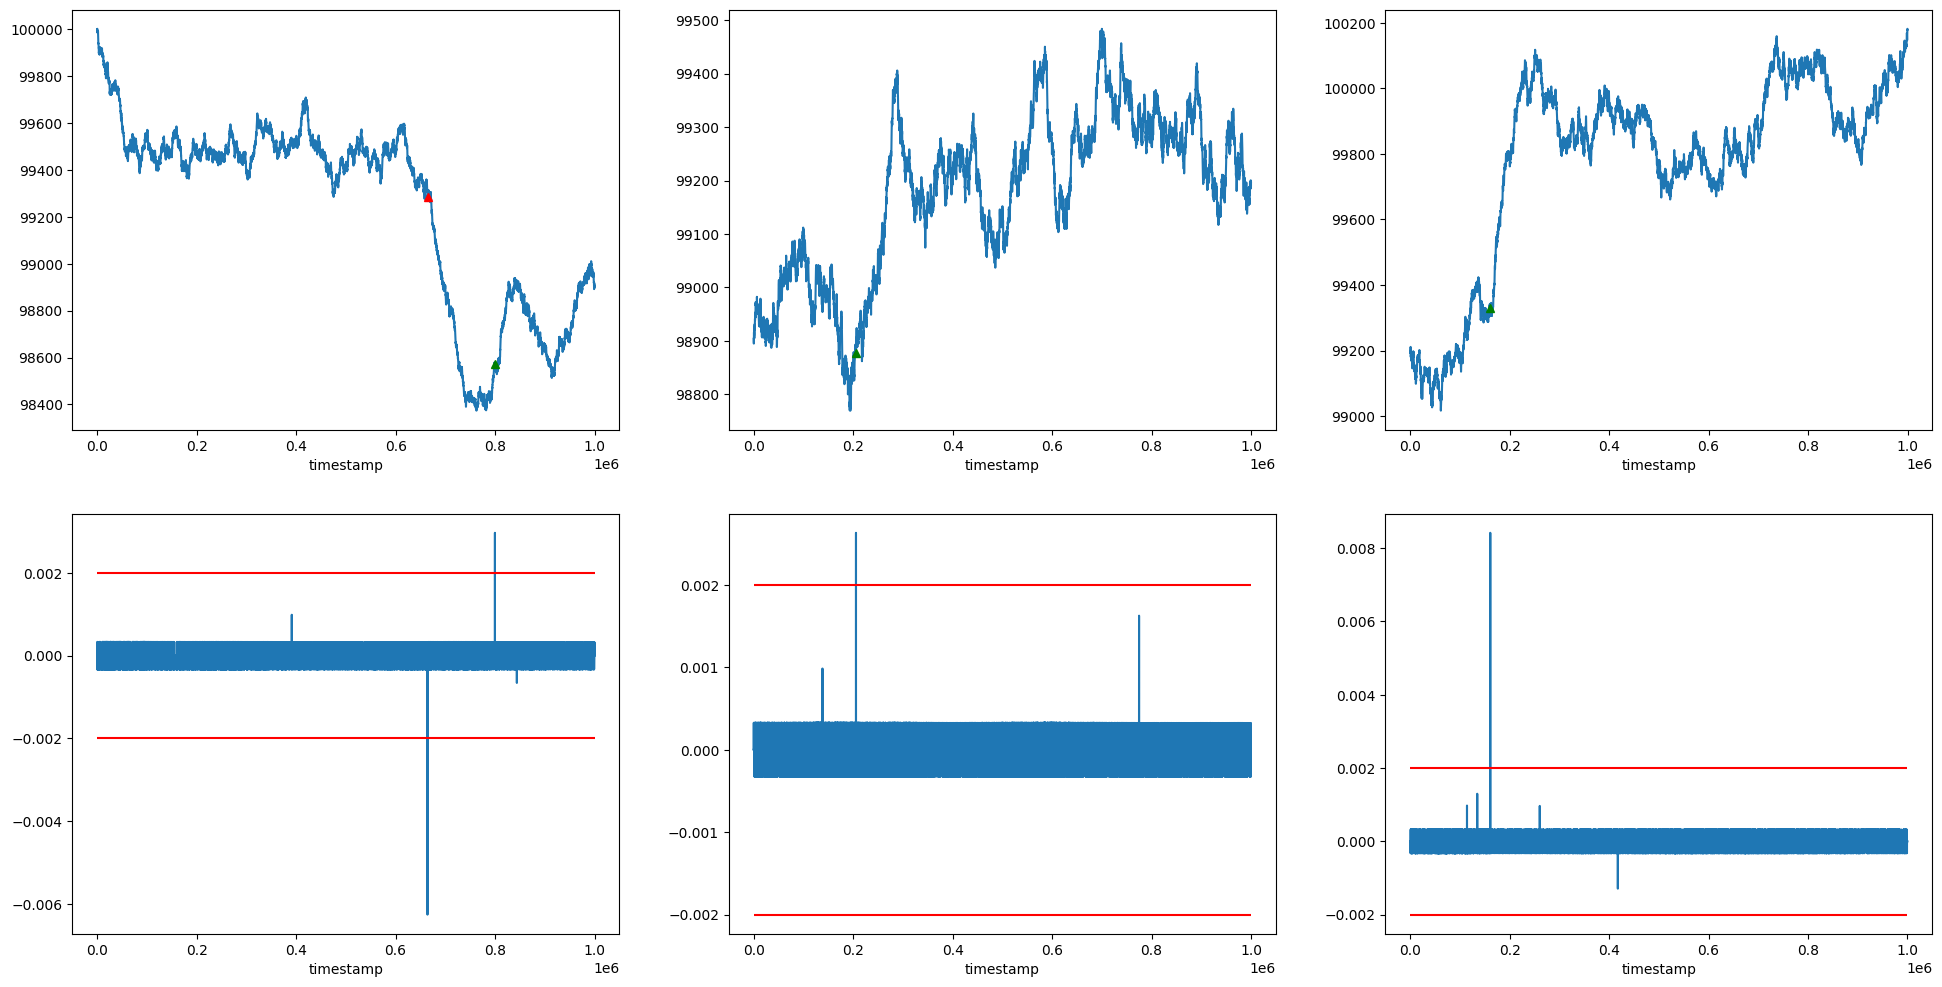

In [298]:
plt.figure(figsize=(24,12))

plt.subplot(2,3,1)
diving_gear_prices0.plot(label = 'mid_price')
diving_gear_prices0[buy_signal0].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices0[sell_signal0].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,4)
dolphin_signal0.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

plt.subplot(2,3,2)
diving_gear_prices1.plot(label = 'mid_price')
diving_gear_prices1[buy_signal1].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices1[sell_signal1].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,5)
dolphin_signal1.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

plt.subplot(2,3,3)
diving_gear_prices2.plot()
diving_gear_prices2[buy_signal2].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
diving_gear_prices2[sell_signal2].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.subplot(2,3,6)
dolphin_signal2.plot()
plt.hlines([0.002, -0.002], 0,1e6, colors=['red'])

# Identifying closing position

<Axes: xlabel='timestamp'>

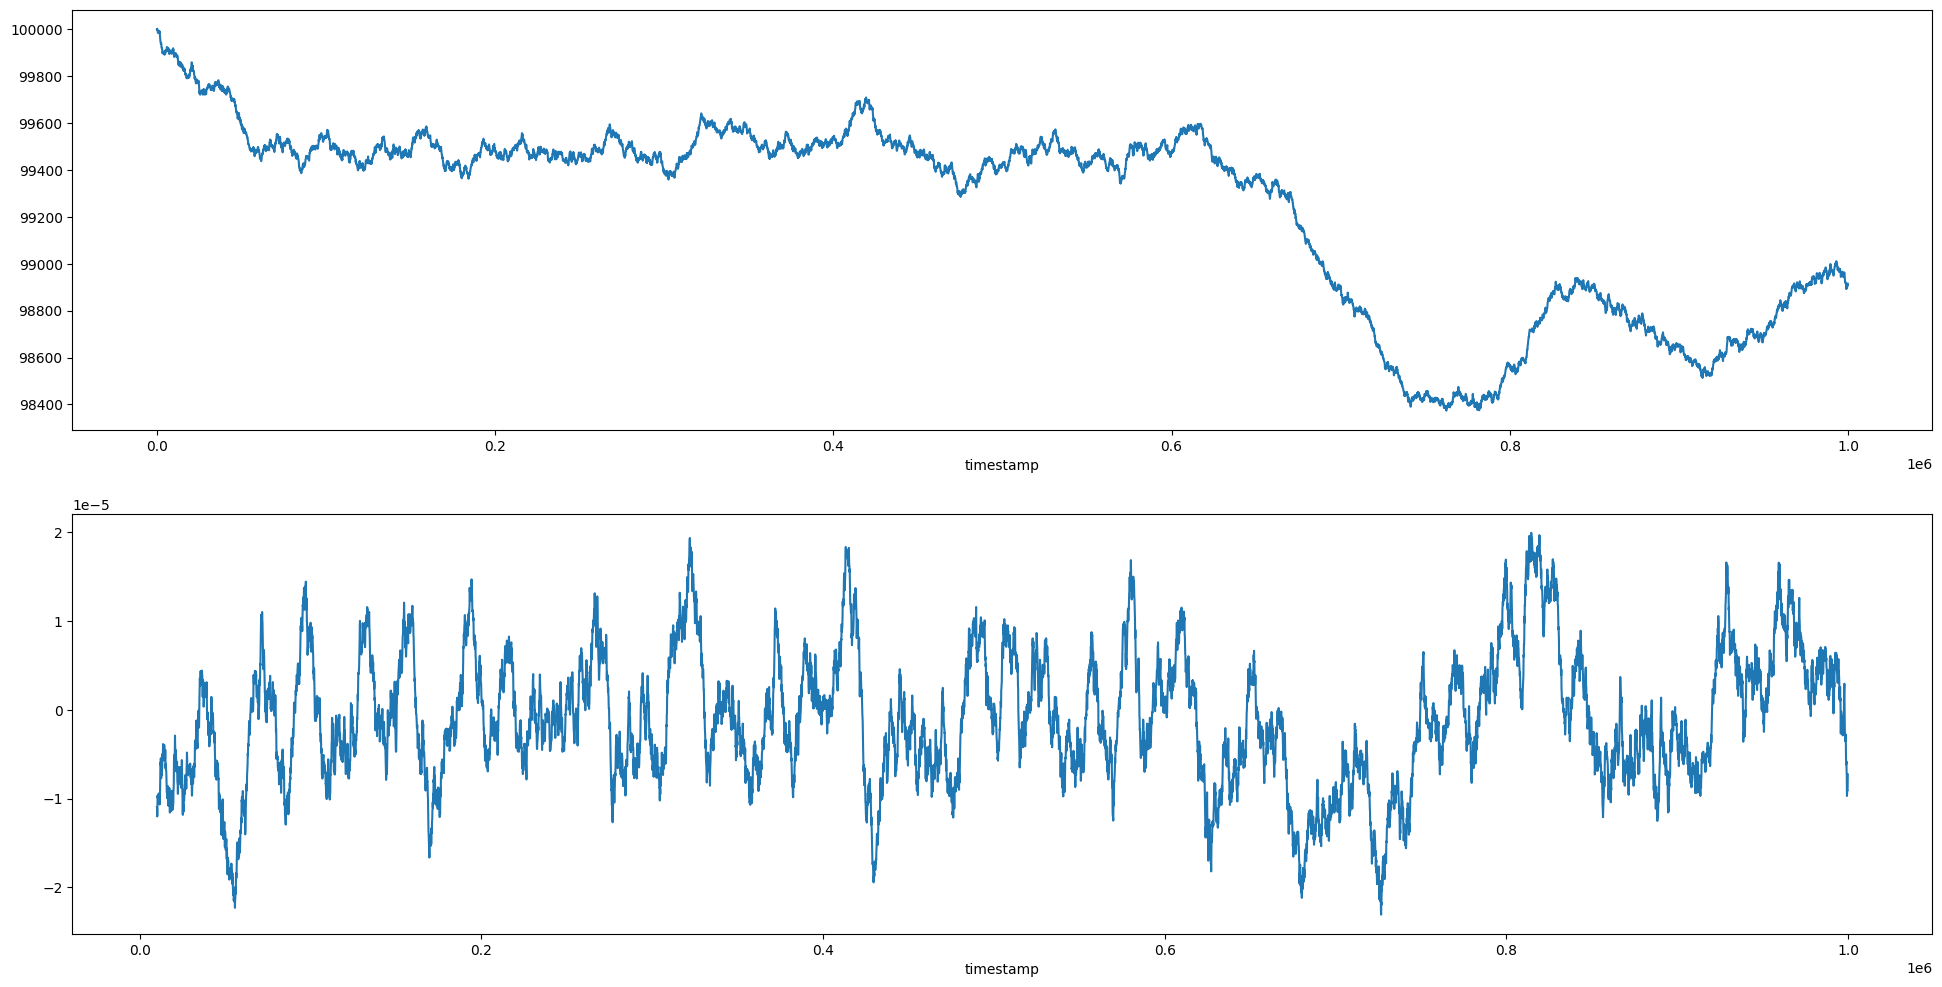

In [279]:
plt.figure(figsize=(24,12))

plt.subplot(2,1,1)
diving_gear_prices0.plot()

plt.subplot(2,1,2)
diving_gear_prices0.pct_change(1).rolling(100).mean().plot()

<Axes: xlabel='timestamp'>

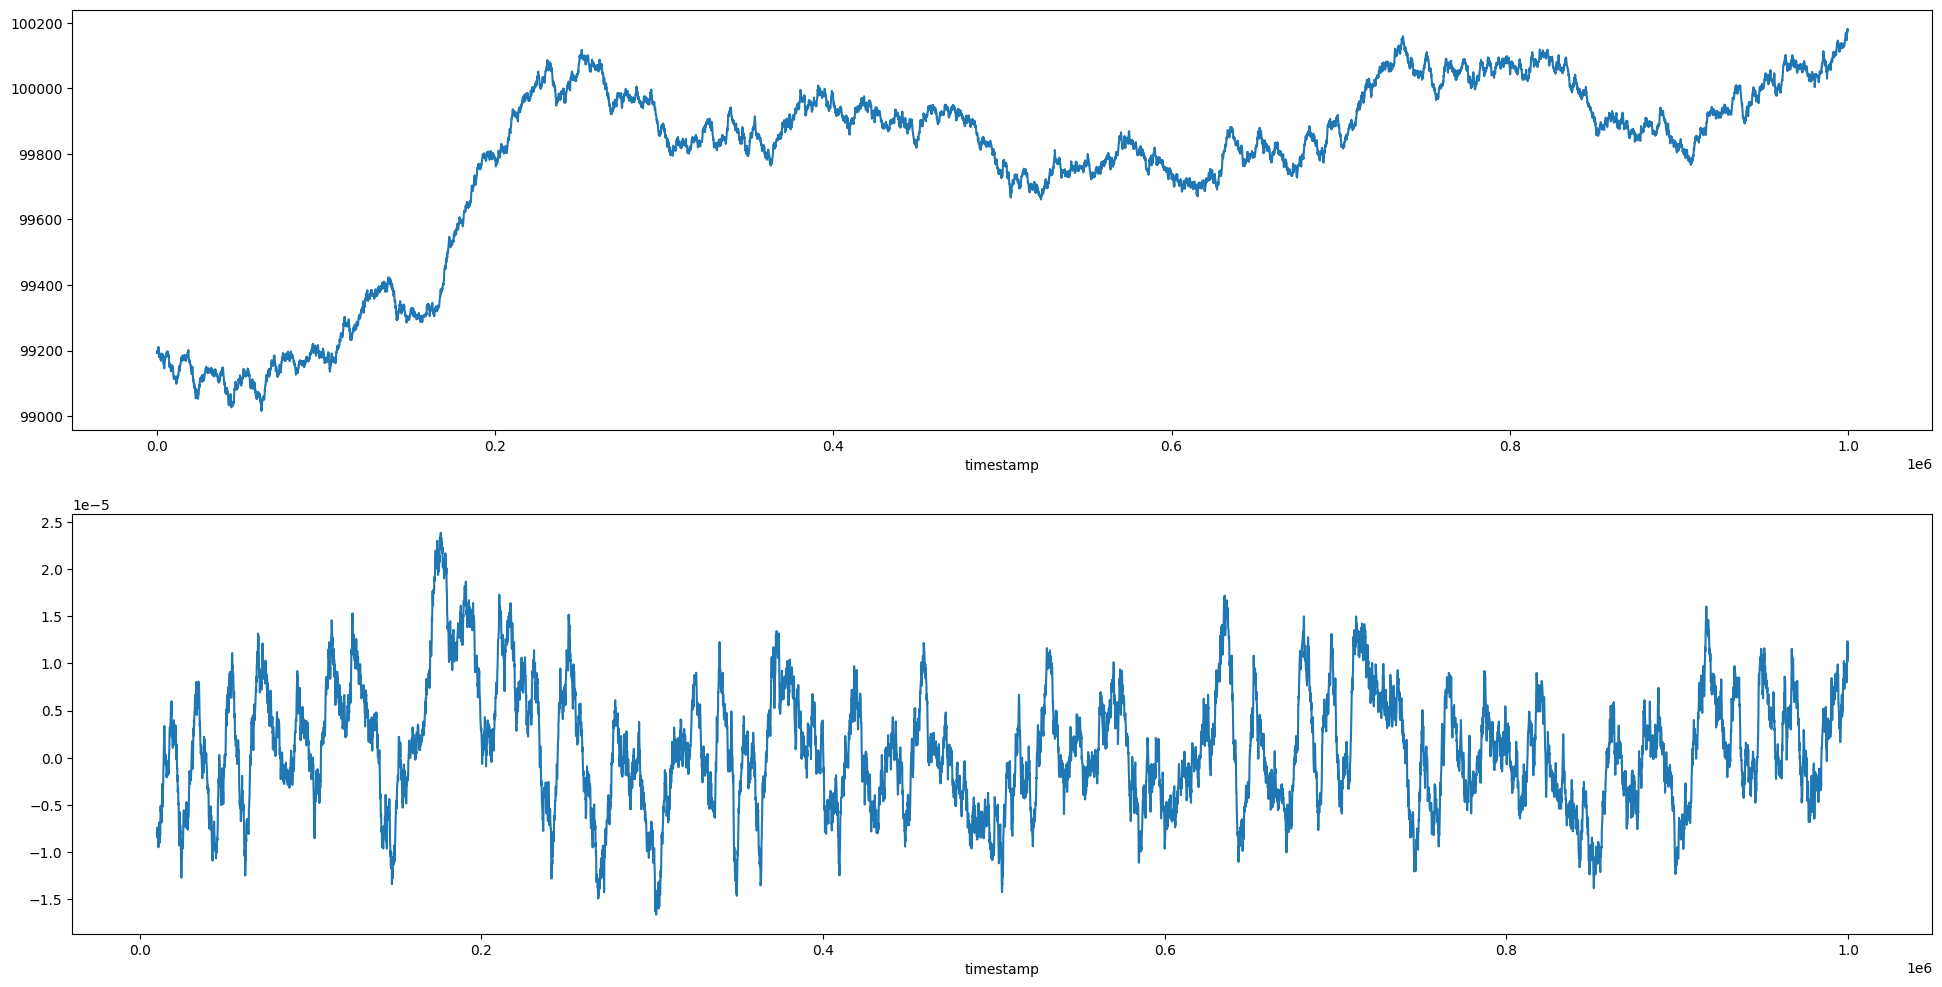

In [278]:
plt.figure(figsize=(24,12))

plt.subplot(2,1,1)
diving_gear_prices2.plot()

plt.subplot(2,1,2)
diving_gear_prices2.pct_change(1).rolling(100).mean().plot()

<Axes: xlabel='timestamp'>

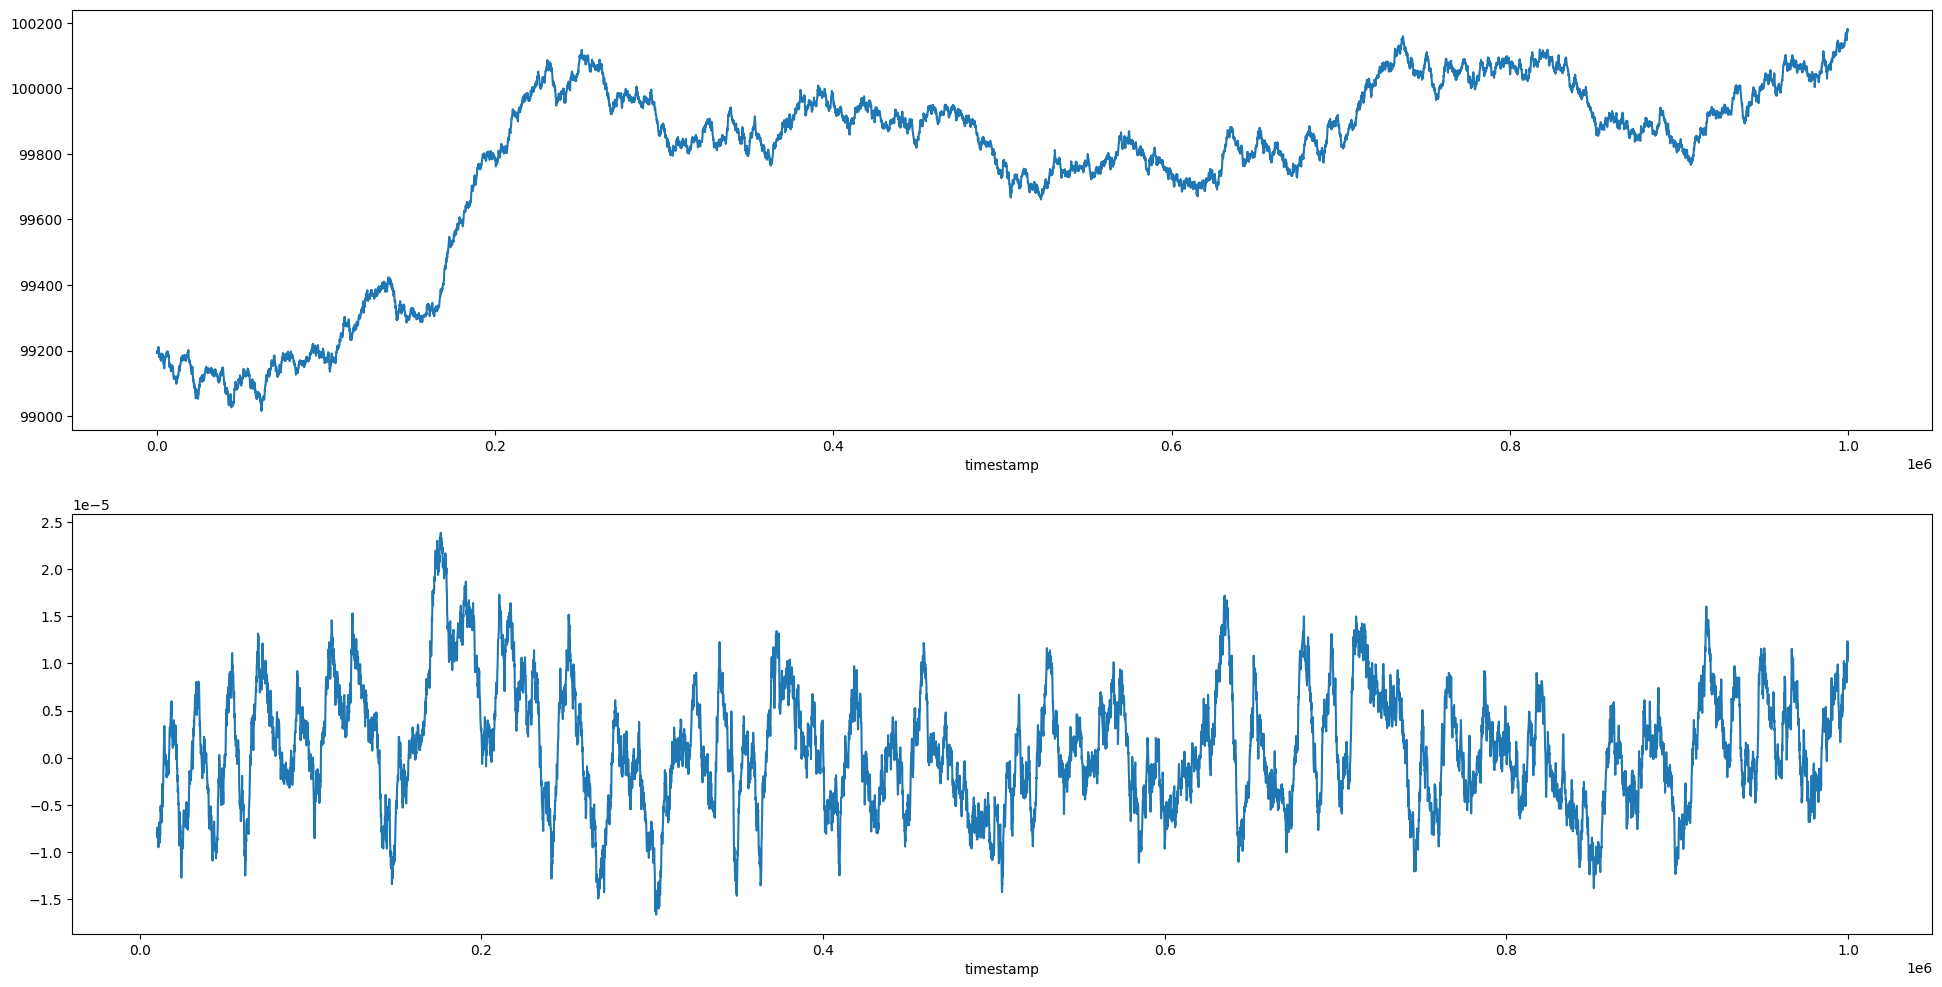

In [272]:
plt.figure(figsize=(24,12))

plt.subplot(2,1,1)
diving_gear_prices0.plot()

plt.subplot(2,1,2)
diving_gear_prices0.pct_change(1).rolling(100).mean().plot()